# How Many Fingers? - PyTorch

In this replository is a small application that uses a CNN to predict how many figers you are holding up. The application does some small image manipulation to extract the edges of your hand against a plain background. It also offers functionality to collect data for training.

Data has been collected within the application by holding up 0 to 5 fingers in the region of interest and recording images. For training ~1500 images of each case has been recorded with an additional ~600 images for validation.

In [1]:
from __future__ import print_function, division
# NEW VM INSTANCE TEST
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from pytorch_model_summary import summary
import time
import os
import copy

# plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Dataset
### > Tensorflow:

First let's load in the data we've collected from the program. We will use kera's `ImageDataGenerator` to not only label the data from the directories but also to slightly augment the data with shifts, rotations, zooms, and mirroring. Mirroring will help to ensure that the data are not biased to a particular handedness.

-------------
### > PyTorch:

Use torchvision and torch.utils.data packages for loading the data.
Slightly augment the training data by with shifts, rotations, zooms, and mirroring.

----- Data augmentation -----
- rescale/resize                => transforms.Resize(300)
- normalize                     => transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.225, 0.225, 0.225]) OR transforms.Normalize(mean=[0.5], std=[0.225])

                                =>ToTensor automatically convert all images between 0 - 1
- rotations(10 degrees)         => transforms.RandomRotation(10)
- shifts(x_position, y_postion) => transforms.RandomAffine(degrees=0, translate=(0.1 ,0.1))
- zoom(0.2)                     => transforms.RandomAffine(degrees=0, scale=(.8, 1))
- mirroring                     => RandomHorizontalFlip()

In [2]:
DATA_PATH = './images/'
BATCH_SIZE = 1
NUM_WORKERS = 4

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(300),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1 ,0.1)),
        transforms.RandomAffine(degrees=0, scale=(.8, 1)),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize(300),
        transforms.Grayscale(),
        transforms.ToTensor()
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=NUM_WORKERS)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [3]:
print("Classes: ", class_names)
print("Number of train samples: ", len(dataloaders['train']))
print("Number of test/validation samples: ", len(dataloaders['val']))

Classes:  ['FIVE', 'FOUR', 'NONE', 'ONE', 'THREE', 'TWO']
Number of train samples:  9081
Number of test/validation samples:  3632


To not bias the model towards any particular label we should have roughly equal examples of each

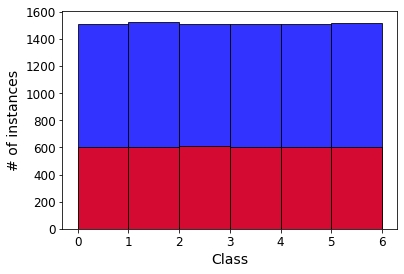

In [4]:
h1,_,_ = plt.hist(np.array(image_datasets['train'].targets), bins=range(0,7), alpha=0.8, color='blue', edgecolor='black')
h2,_,_ = plt.hist(np.array(image_datasets['val'].targets),  bins=range(0,7), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class');

(1, 300, 300)
(300, 300, 1)


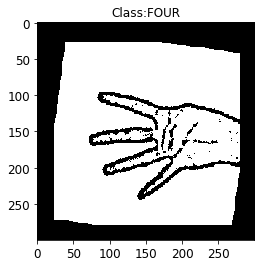

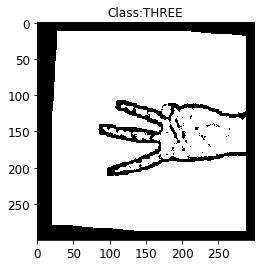

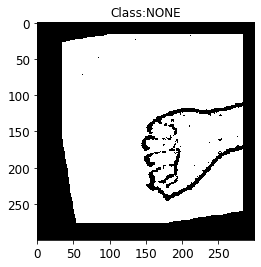

In [5]:
images, _ = next(iter(dataloaders['train']))
print(images[0].numpy().shape)
print(np.transpose(images[0].numpy()).shape)

def imshow(img):
    np_img = np.transpose(img.numpy())   
    plt.imshow(np_img, cmap='gray')
    plt.show()

for i in range(3):
    # get some random training images
    dataiter = iter(dataloaders['train'])
    images, classes = dataiter.next()
    # show images
    plt.title('Class:{}'.format(class_names[classes]))
    imshow(torchvision.utils.make_grid(images))

Next we'll do some quick checks to make sure our data are labeled correctly

In [6]:
# double check things aren't mixed up
image_datasets['train'].class_to_idx == image_datasets['val'].class_to_idx

True

## Convolutional Neural Net

The data looks resonable so now we will define a CNN model to train and use within our application. The model below has not been thoroughly optimized but seems to perform well for our purposes.

--------------


- kernel_size =>  a 2-tuple specifying the width and height of the 2D convolution window. (A single value represents the same value for width and heigth)

***For nn.Linear you would have to provide the number if in_features first, which can be calculated using your layers and input shape or just by printing out the shape of the activation in your forward method.



In [7]:
# model with input_shape = (300, 300, 1)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input_channels = 1, output channels = 6, kernel_size=(3,3)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2) # same as pool_size=(2,2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)

        self.hidden= nn.Linear(128*16*16, 512) # The linear layer should therefore take 128*16*16=327688 input features
        self.drop = nn.Dropout(0.7) # zero out 70% of activations (only keep 30% )
        self.out = nn.Linear(512, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # -> [batch_size, 32, 298, 298] => The 32 is given by the number of kernels your conv layer is using.
                                                                    # Since you are not using any padding and leave the stride and dilation as 1,
                                                                    # a kernel size of 3 will crop 1 pixel in each spatial dimension.
                                                                    # Therefore you’ll end up with 32 activation maps of spatial size 298x298.
        # print(x.shape)
        x = self.pool(x) # -> [batch_size, 32, 149, 149] => The max pooling layer will halve the spatial size
        # print(x.shape)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1) # -> [batch_size, 128*16*16=327688]
        x = F.relu(self.hidden(x)) # -> [batch_size, 512]
        x = self.drop(x) # -> [batch_size, 512]
        x = F.softmax(self.out(x), dim=1) # -> [batch_size, 6]
        return x

model = CNN()

In [8]:
""" **********------ FOR TESTING ------**********"""
# batch_size, C, H, W = 1, 1, 300, 300
# x = torch.randn(batch_size, C, H, W)
# output = model(x)

' **********------ FOR TESTING ------**********'

In [9]:
print(summary(model, torch.zeros((1, 1, 300, 300)), show_input=False, show_hierarchical=True))

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 32, 298, 298]             320             320
       MaxPool2d-2     [1, 32, 149, 149]               0               0
          Conv2d-3     [1, 64, 147, 147]          18,496          18,496
          Conv2d-4      [1, 128, 71, 71]          73,856          73,856
          Conv2d-5      [1, 128, 33, 33]         147,584         147,584
          Linear-6              [1, 512]      16,777,728      16,777,728
         Dropout-7              [1, 512]               0               0
          Linear-8                [1, 6]           3,078           3,078
Total params: 17,021,062
Trainable params: 17,021,062
Non-trainable params: 0
-------------------------------------------------------------------------


===================================== Hierarchical Summary =====================================

CNN(
  (conv1): C

Construct an loss function, and an optimizer. 

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adadelta(model.parameters(), lr=0.001)

# Construct learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


## Training

-  Training will save the best model.

- We are not doing any hyper-parameter optimization so we will not define a separate testing and validation set. We can however evaluate our model further in real time within the application.


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (hidden): Linear(in_features=32768, out_features=512, bias=True)
  (drop): Dropout(p=0.7, inplace=False)
  (out): Linear(in_features=512, out_features=6, bias=True)
)

In [11]:
def train(model, criterion, optimizer, scheduler, num_epochs=32):
    """
    arguments:
    model
    criterion
    optimizer
    scheduler
    num_epochs (default 32)
    
    returns:
    trained model
    """
    training_start_time = time.time()
    # number of batch iterations before a training epoch is considered finished
    steps_per_epoch = 71
    # number of batch iterations before a validation epoch is considered finished
    validation_steps=28
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        # initialize variables to monitor training and validation loss & accuracy
        running_loss = 0.0
        running_corrects = 0
        epoch_start_time = time.time()
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(dataloaders['train']):
            # move to GPU or CPU
            data, target = data.to(device), target.to(device)
            ## find the loss and update the model parameters accordingly
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, preds = torch.max(output, 1)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record the average training loss and accuracy
            running_loss += loss.item() * data.size(0)
            running_corrects += torch.sum(preds == target.data)   
            
#             scheduler.step()
#             if (batch_idx+1) % steps_per_epoch == 0:
#                 print(batch_idx)
#                 break

        # calculate training losses
        train_epoch_loss = running_loss / dataset_sizes['train']
        train_epoch_acc = running_corrects.double() / dataset_sizes['train']
            
        ######################    
        # validate the model #
        ######################
        running_loss = 0.0
        running_corrects = 0
        model.eval()
        for batch_idx, (data, target) in enumerate(dataloaders['val']):
            # move to GPU or CPU
            data, target = data.to(device), target.to(device)
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            running_loss += loss.item() * data.size(0)
            running_corrects += torch.sum(preds == target.data)
            
#             if (batch_idx+1) % validation_steps == 0:
#                 print(batch_idx)
#                 break
        
        # calculate validation losses
        val_epoch_loss = running_loss / dataset_sizes['val']
        val_epoch_acc = running_corrects.double() / dataset_sizes['val']          
            
        # print training/validation statistics 
        print('>>> Training Loss: {:.6f} --- Acc: {:.4f} | Validation Loss: {:.6f} --- Acc: {:.4f} '.format(
            train_epoch_loss,
            train_epoch_acc,
            val_epoch_loss,
            val_epoch_acc
            ))
        epoch_time_elapsed = time.time() - epoch_start_time
        print('>>> {:.0f}m {:.0f}s'.format(epoch_time_elapsed // 60, epoch_time_elapsed % 60))
    
    total_time_elapsed = time.time() - training_start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

    return model

In [11]:
# Test #1 (OLDER CODE => validation loss did not decrease & val accurancy is not increasing above 45%)
# Training complete in 61m 18s
# Best val Acc: 0.449339
# ---------------------------------------------------------------------------------------------------------------
# Test #2 (New code, w/o Scheduler => training loss/acc improved alot; val loss improved alot, accuracy is stagnant at less than 2%!!)
# Epoch 40/40
# >>> Training Loss: 0.339579 --- Acc: 0.8838 | Validation Loss: 0.141986 --- Acc: 0.1666 
# >>> 1m 29s
# Training complete in 59m 33s
# ---------------------------------------------------------------------------------------------------------------
# Test #3 (Changed dropout p value => accuracy is stagnant still; stopped model right away )

# ---------------------------------------------------------------------------------------------------------------
# Test #4 (added missing softmax activation layer => ) accuracy is stagnant still; training loss/acc got worse;


In [12]:
# Test #4 
NUM_EPOCHS = 40
PATH = './model.pth'
best_model = train(model, criterion, optimizer, lr_scheduler, num_epochs=NUM_EPOCHS)
torch.save(best_model.state_dict(), PATH)

Epoch 1/40
>>> Training Loss: 1.791715 --- Acc: 0.1660 | Validation Loss: 1.791481 --- Acc: 0.1666 
>>> 1m 40s
Epoch 2/40
>>> Training Loss: 1.791423 --- Acc: 0.1721 | Validation Loss: 1.791094 --- Acc: 0.1666 
>>> 1m 38s
Epoch 3/40
>>> Training Loss: 1.790912 --- Acc: 0.1846 | Validation Loss: 1.790193 --- Acc: 0.1663 
>>> 1m 40s
Epoch 4/40
>>> Training Loss: 1.789417 --- Acc: 0.1914 | Validation Loss: 1.787590 --- Acc: 0.1666 
>>> 1m 40s
Epoch 5/40
>>> Training Loss: 1.784281 --- Acc: 0.2088 | Validation Loss: 1.775816 --- Acc: 0.1666 
>>> 1m 39s
Epoch 6/40
>>> Training Loss: 1.760615 --- Acc: 0.2739 | Validation Loss: 1.727714 --- Acc: 0.1663 
>>> 1m 40s
Epoch 7/40
>>> Training Loss: 1.718233 --- Acc: 0.3131 | Validation Loss: 1.651847 --- Acc: 0.1669 
>>> 1m 40s
Epoch 8/40
>>> Training Loss: 1.675389 --- Acc: 0.3730 | Validation Loss: 1.577726 --- Acc: 0.1666 
>>> 1m 40s
Epoch 9/40
>>> Training Loss: 1.636991 --- Acc: 0.4099 | Validation Loss: 1.507053 --- Acc: 0.1669 
>>> 1m 40s
E

In [26]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.
                plt.title('predicted: {}'.format(class_names[preds[j]]))
#                 set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

TypeError: Invalid shape (300, 300, 1) for image data

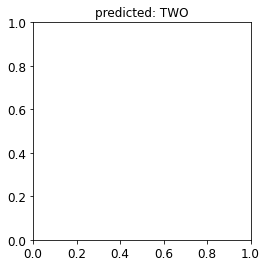

In [27]:
visualize_model(best_model)

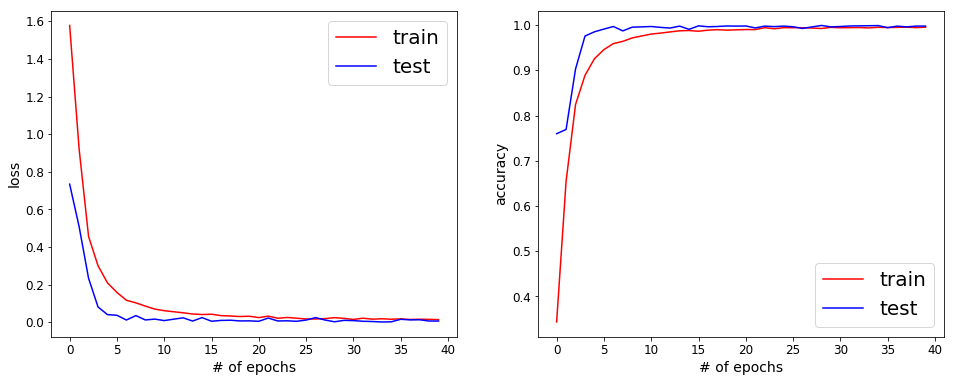

In [13]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('loss')
plt.xlabel('# of epochs')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['acc'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_acc'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('accuracy')
plt.xlabel('# of epochs')

Since there is dropout being applied in the network and additional (random) augmentation being applied to the training set it is not surprising that the validation set is out-performing the training set. Nonetheless, it seems that in either case we're able to achieve near perfect ( > 99% ) accuracy.

This model is able to hence surpass human performance when the human is severely concussed or inebriated.

## Performance and Error Analysis

Our model is performing so well that there are not many cases where the model has failed for us to understand our model better. To try and probe a bit deeper I will expand the testing set and apply some augmentation.

In [14]:
test_datagen  = ImageDataGenerator( rescale=1./255, 
                                    rotation_range=10.,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True
                                  )

test_gen = test_datagen.flow_from_directory(
        'images/test/',
        target_size=(300, 300),
        color_mode='grayscale',
        batch_size=nbatch,
        classes=['NONE','ONE','TWO','THREE','FOUR','FIVE'],
        class_mode='categorical'
    )

Found 3632 images belonging to 6 classes.


In [23]:
X_test, y_test = [], []
for ibatch, (X, y) in enumerate(test_gen):
    X_test.append(X)
    y_test.append(y)
    ibatch += 1
    if (ibatch == 5*28): break

# Concatenate everything together
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
y_test = np.int32([np.argmax(r) for r in y_test])

# Get the predictions from the model and calculate the accuracy
y_pred = np.int32([np.argmax(r) for r in model.predict(X_test)])
match = (y_test == y_pred)
print('Testing Accuracy = %.2f%%' % (np.sum(match)*100/match.shape[0]))

Testing Accuracy = 99.25%


In [24]:
nomatch = (y_test != y_pred)
bad_pred = y_pred[nomatch]
bad_true = y_test[nomatch]
bad_img = X_test[nomatch]
print('%d examples of bad predictions' % bad_pred.size)

131 examples of bad predictions


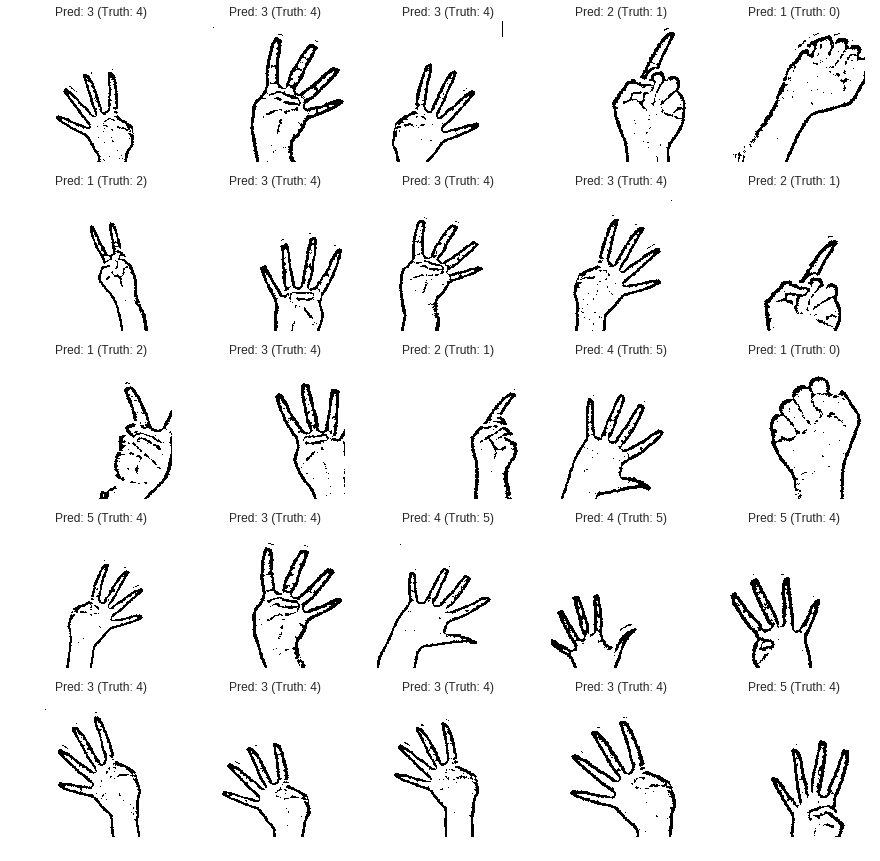

In [34]:
plt.figure(figsize=(15,15))
for i in range(min(bad_true.size,25)):
    plt.subplot(5,5,i+1)
    i+=75
    plt.title('Pred: %d (Truth: %d)' % (bad_pred[i], bad_true[i]))
    plt.axis('off')
    plt.imshow(bad_img[i][:,:,0], cmap='gray')

There are a couple examples above where fingers are moved out of the frame during augmentation and the prediction is henced flawed. These issues are likely also present during training and it's hard to fault the model for getting predictions wrong in these fringe cases. 

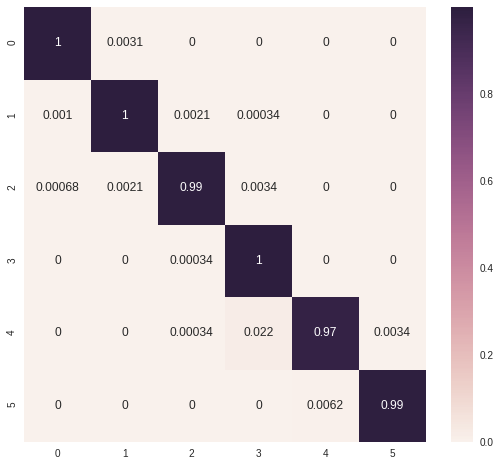

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
plt.figure(figsize=(9,8))
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum(axis=1)
sn.heatmap(cm, annot=True);

The confusion matrix helps summarize the cases that are misclasified as shown above. In general we see that the networks seems to usually under-count the number of fingers and this is probably at least in part to the issues in augmentation that we noted previously. The network performs quite well in general but has the most trouble counting four fingers, usually confusing it for three fingers. This issue seems most prevelant when the four fingers are quite rotated to the side. As the convolutional network is not rotation invariant, this issue could possibly be improved with more data or by adjusting the model. For the purposes of this project this issue is deemed acceptable but could be improved in the future. 